# Import

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\codexjoe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [16]:
data1 = pd.read_csv('small-complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False, sep=',')

In [17]:
data1.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/27/20,Mortgage,Home equity loan or line of credit (HELOC),Trouble during payment process,None,NaN,None,TD BANK US HOLDING COMPANY,NY,12077,None,NaN,Referral,04/27/20,Closed with explanation,Yes,NaN,3625761
1,03/23/20,Debt collection,I do not know,Written notification about debt,Didn't receive enough information to verify debt,NaN,None,ERC,LA,70722,None,Consent not provided,Web,03/23/20,Closed with explanation,Yes,NaN,3576463
2,05/19/20,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,None,"EQUIFAX, INC.",NJ,07036,None,Consent not provided,Web,05/19/20,Closed with explanation,Yes,NaN,3658230
3,02/04/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91343,None,Consent not provided,Web,02/04/20,Closed with explanation,Yes,NaN,3519636
4,02/18/20,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,None,"EQUIFAX, INC.",FL,34639,None,Consent not provided,Web,02/19/20,Closed with explanation,Yes,NaN,3536173


In [5]:
data = data1[["Product","Consumer complaint narrative"]]

In [6]:
data.head(15)

,Product,Consumer complaint narrative
0,Mortgage,NaN
1,Debt collection,NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,"Credit reporting, credit repair services, or o...",NaN
5,Debt collection,NaN
6,"Money transfer, virtual currency, or money ser...",NaN
7,Debt collection,NaN
8,Debt collection,NaN
9,"Credit reporting, credit repair services, or o...",NaN


In [7]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    89538
Debt collection                                                                 20817
Credit card or prepaid card                                                     13433
Mortgage                                                                         9890
Checking or savings account                                                      9146
Money transfer, virtual currency, or money service                               2596
Vehicle loan or lease                                                            2513
Student loan                                                                     2365
Payday loan, title loan, or personal loan                                        1842
Name: Product, dtype: int64

In [8]:
data.isnull().sum()

Product                             0
Consumer complaint narrative    85168
dtype: int64

In [18]:
data.dropna(axis = 0, inplace = True)

In [19]:
data.head()

,Product,Consumer complaint narrative
18,"Credit reporting, credit repair services, or o...",REMOVE THE ATTACHED FTC VIOLATIONS
19,"Payday loan, title loan, or personal loan",One month ago I contacted green sky requesting...
20,"Credit reporting, credit repair services, or o...",I decided to get my credit pulled due to a bil...
21,Checking or savings account,OK SO I WAS XXXX BACK IN XX/XX/XXXX TO BE EXA...
22,Mortgage,Why didn't the assigned SPOC ever call or get ...


<AxesSubplot:>

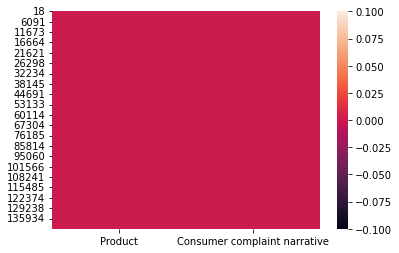

In [20]:
sns.heatmap(data.isnull())

# Preprocessing & Vizz

In [21]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Money transfers', 'Product'] = 'Money transfer, virtual currency, or money service'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'


In [22]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"

data.loc[data['Product'] == 'Prepaid card', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan', 'Product'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service', 'Product'] = 'Other financial service'

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']


In [23]:
data = data.reset_index(drop=True)

In [24]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",REMOVE THE ATTACHED FTC VIOLATIONS
1,"Payday loan, title loan, or personal loan",One month ago I contacted green sky requesting...
2,"Credit reporting, credit repair services, or o...",I decided to get my credit pulled due to a bil...
3,Checking or savings account,OK SO I WAS XXXX BACK IN XX/XX/XXXX TO BE EXA...
4,Mortgage,Why didn't the assigned SPOC ever call or get ...
...,...,...
66967,Debt collection,Someone used my identity and I have tried to c...
66968,"Credit reporting, credit repair services, or o...","On XXXX, XXXX, and XXXX, I have paid {$1000.00..."
66969,"Credit reporting, credit repair services, or o...",I am a XXXX year old woman who is continuously...
66970,Mortgage,I am attempting to work with my mortgage compa...


In [25]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    36147
Debt collection                                                                 10279
Credit card or prepaid card                                                      6901
Mortgage                                                                         4846
Checking or savings account                                                      3491
Money transfer, virtual currency, or money service                               1512
Vehicle loan or lease                                                            1380
Student loan                                                                     1364
Payday loan, title loan, or personal loan                                        1052
Name: Product, dtype: int64

In [26]:
data.Product.value_counts().index

Index(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Credit card or prepaid card', 'Mortgage',
       'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Vehicle loan or lease', 'Student loan',
       'Payday loan, title loan, or personal loan'],
      dtype='object')

In [27]:
data.Product.value_counts().values

array([36147, 10279,  6901,  4846,  3491,  1512,  1380,  1364,  1052],
      dtype=int64)

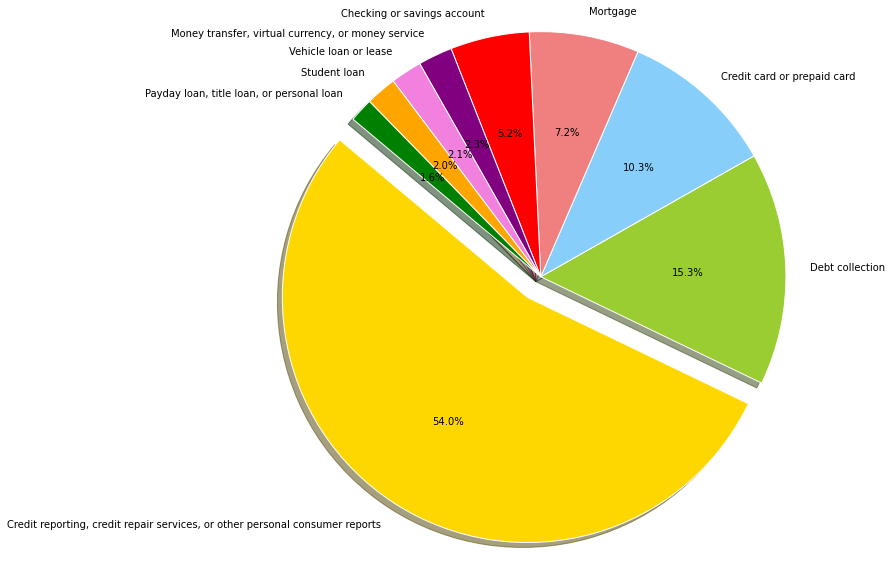

In [28]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [29]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [30]:
complaint_product(11000, data)

Navient provided incoherent response to my previous complaint. 

Company 's Response Thank you for reaching out to the CFPB with your concerns regarding your student loan account. Our records confirm that your Income Based Repayment ( IBR ) renewal was processed on XX/XX/2020 ; however, in response to the impact of COVID-19, on Friday, XX/XX/2020, President Trump announced that the U.S. Department of Education ( ED ) will waive interest on all federally held student loans and automatically postpone payments through XX/XX/2020. Your interest rates have been reduced to 0.00 percent during this period. Interest that accrued prior to the suspension will remain your responsibility. During this time, no payment will be due. This forbearance will not count against your voluntary forbearance time. Although you will not be required to make monthly payments during this specific administrative forbearance period, payments you would have been required to make under IBR through XX/XX/2020 will coun

In [32]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [33]:
# for i in data.loc[:, 'Consumer complaint narrative'].index:
#     data.loc[i, 'Consumer complaint narrative'] = clean_text(data.loc[i, 'Consumer complaint narrative'])
 #OR
data['Consumer complaint narrative'] = pd.Series([clean_text(i) for i in data['Consumer complaint narrative']])

In [34]:
data['Consumer complaint narrative']


0                           remove attached ftc violations
1        one month ago contacted green sky requesting d...
2        decided get credit pulled due bill received ma...
3        ok back eact make story short got basically sp...
4        didnt assigned spoc ever call get back emailed...
                               ...                        
66967    someone used identity tried contact company he...
66968    paid toward cc mastercard owed card balance ba...
66969    year old woman continuously badgered refuses d...
66970    attempting work mortgage company guild mortgag...
66971    requested forebearance earlier year asked back...
Name: Consumer complaint narrative, Length: 66972, dtype: object

In [35]:
# After cleaning
complaint_product(238, data)

made numerous phone calls letter credit bureaus eperian reporting non data information credit bureaus listed dates event information erroneous outdated eperiencing amount due current status home loan denied credit due non data information credit report dates supposedly representing payments time ok status credit important working diligently towards situation requesting eperian please work together correcting issue
------------------------------
Product :  Credit reporting, credit repair services, or other personal consumer reports


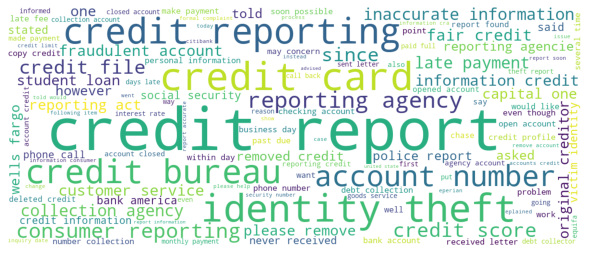

In [36]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [157]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]


In [168]:
number_words




[4,
 97,
 34,
 100,
 23,
 207,
 25,
 9,
 113,
 15,
 55,
 19,
 148,
 37,
 183,
 6,
 22,
 136,
 137,
 183,
 76,
 63,
 55,
 128,
 38,
 81,
 6,
 68,
 32,
 58,
 33,
 193,
 12,
 8,
 29,
 316,
 62,
 17,
 162,
 15,
 41,
 41,
 74,
 207,
 981,
 20,
 6,
 78,
 67,
 71,
 37,
 77,
 163,
 82,
 53,
 158,
 71,
 77,
 34,
 34,
 139,
 64,
 73,
 39,
 264,
 54,
 287,
 34,
 106,
 71,
 6,
 116,
 24,
 40,
 40,
 104,
 110,
 42,
 169,
 98,
 18,
 159,
 10,
 84,
 24,
 45,
 46,
 50,
 10,
 43,
 64,
 34,
 204,
 147,
 110,
 43,
 10,
 171,
 171,
 190,
 238,
 65,
 41,
 6,
 788,
 17,
 195,
 143,
 52,
 1308,
 65,
 4,
 99,
 226,
 205,
 20,
 61,
 187,
 26,
 19,
 40,
 16,
 33,
 6,
 44,
 200,
 98,
 84,
 46,
 204,
 256,
 77,
 35,
 398,
 45,
 92,
 14,
 106,
 171,
 16,
 158,
 83,
 46,
 37,
 200,
 139,
 86,
 189,
 56,
 87,
 13,
 438,
 53,
 145,
 36,
 174,
 227,
 81,
 33,
 85,
 84,
 92,
 14,
 55,
 170,
 27,
 169,
 33,
 21,
 53,
 68,
 137,
 35,
 19,
 8,
 73,
 115,
 35,
 119,
 76,
 14,
 40,
 20,
 195,
 118,
 34,
 186,
 211,
 12,
 83

In [165]:
num_arr = pd.DataFrame(number_words)

num_arr.value_counts().sort_values(ascending=False)

35      1141
32       920
36       863
20       848
28       831
        ... 
1273       1
514        1
1275       1
1102       1
777        1
Length: 900, dtype: int64

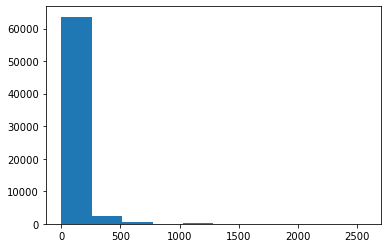

In [166]:
plt.hist(number_words)
plt.show()

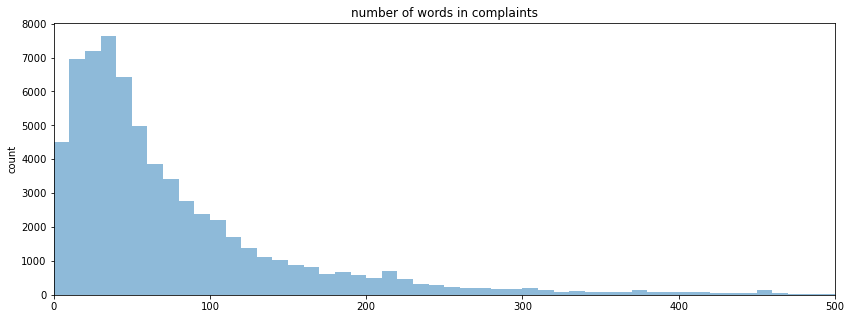

In [162]:
# fixed bin size

plt.figure(figsize=(14,5))
bins = np.arange(0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complaints')
plt.ylabel('count')

plt.show()

<AxesSubplot:>

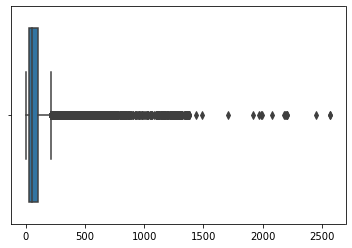

In [160]:
sns.boxplot(number_words)

# Multi-Class Text Classification LSTM 

In [174]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [169]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43939 unique tokens.


In [175]:
word_index

{'credit': 1,
 'account': 2,
 'information': 3,
 'report': 4,
 'reporting': 5,
 'accounts': 6,
 'payment': 7,
 'would': 8,
 'consumer': 9,
 'debt': 10,
 'received': 11,
 'loan': 12,
 'company': 13,
 'card': 14,
 'bank': 15,
 'never': 16,
 'told': 17,
 'time': 18,
 'letter': 19,
 'also': 20,
 'called': 21,
 'made': 22,
 'number': 23,
 'dispute': 24,
 'sent': 25,
 'collection': 26,
 'payments': 27,
 'due': 28,
 'one': 29,
 'get': 30,
 'days': 31,
 'back': 32,
 'file': 33,
 'please': 34,
 'date': 35,
 'balance': 36,
 'identity': 37,
 'agency': 38,
 'paid': 39,
 'call': 40,
 'amount': 41,
 'late': 42,
 'said': 43,
 'pay': 44,
 'money': 45,
 'section': 46,
 'remove': 47,
 'mortgage': 48,
 'phone': 49,
 'theft': 50,
 'could': 51,
 'fraudulent': 52,
 'still': 53,
 'name': 54,
 'request': 55,
 'even': 56,
 'removed': 57,
 'asked': 58,
 'inaccurate': 59,
 'reported': 60,
 'opened': 61,
 'since': 62,
 'complaint': 63,
 'contacted': 64,
 'make': 65,
 'bureaus': 66,
 'us': 67,
 'check': 68,
 'stat

In [177]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66972, 250)


In [178]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66972, 9)


In [180]:
labels

['Checking or savings account',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

In [182]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(46880, 250) (46880, 9)
(20092, 250) (20092, 9)


**Expected Output :**
(35449, 250) (35449, 9)
(8863, 250) (8863, 9)

In [186]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=250))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 9)                 909       
                                                                 
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param   
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909    
_________________________________________________________________

Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0


In [187]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
660/660 [==============================] - 537s 805ms/step - loss: 0.9910 - accuracy: 0.6715 - val_loss: 0.7197 - val_accuracy: 0.7831
Epoch 2/5
660/660 [==============================] - 537s 814ms/step - loss: 0.7917 - accuracy: 0.7487 - val_loss: 0.7991 - val_accuracy: 0.7664
Epoch 3/5
660/660 [==============================] - 536s 812ms/step - loss: 0.6960 - accuracy: 0.7794 - val_loss: 0.6614 - val_accuracy: 0.7944
Epoch 4/5
660/660 [==============================] - 578s 876ms/step - loss: 0.5589 - accuracy: 0.8207 - val_loss: 0.6471 - val_accuracy: 0.7956
Epoch 5/5
660/660 [==============================] - 530s 802ms/step - loss: 0.5283 - accuracy: 0.8290 - val_loss: 0.6903 - val_accuracy: 0.7875


In [190]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

628/628 [==============================] - 38s 60ms/step - loss: 0.6988 - accuracy: 0.7852
Test set
  Loss: 0.70
  Accuracy: 0.79


Test set

  Loss: 0.66
  
  Accuracy: 0.80

In [191]:
Y_pred = model.predict(X_test)

628/628 [==============================] - 37s 58ms/step


In [193]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [194]:
predicted_classes

array([1, 3, 3, ..., 2, 2, 2], dtype=int64)

In [197]:
# Code Here
expected_classes = np.argmax(Y_test, axis = 1)

In [199]:
expected_classes

array([1, 2, 3, ..., 2, 2, 2], dtype=int64)

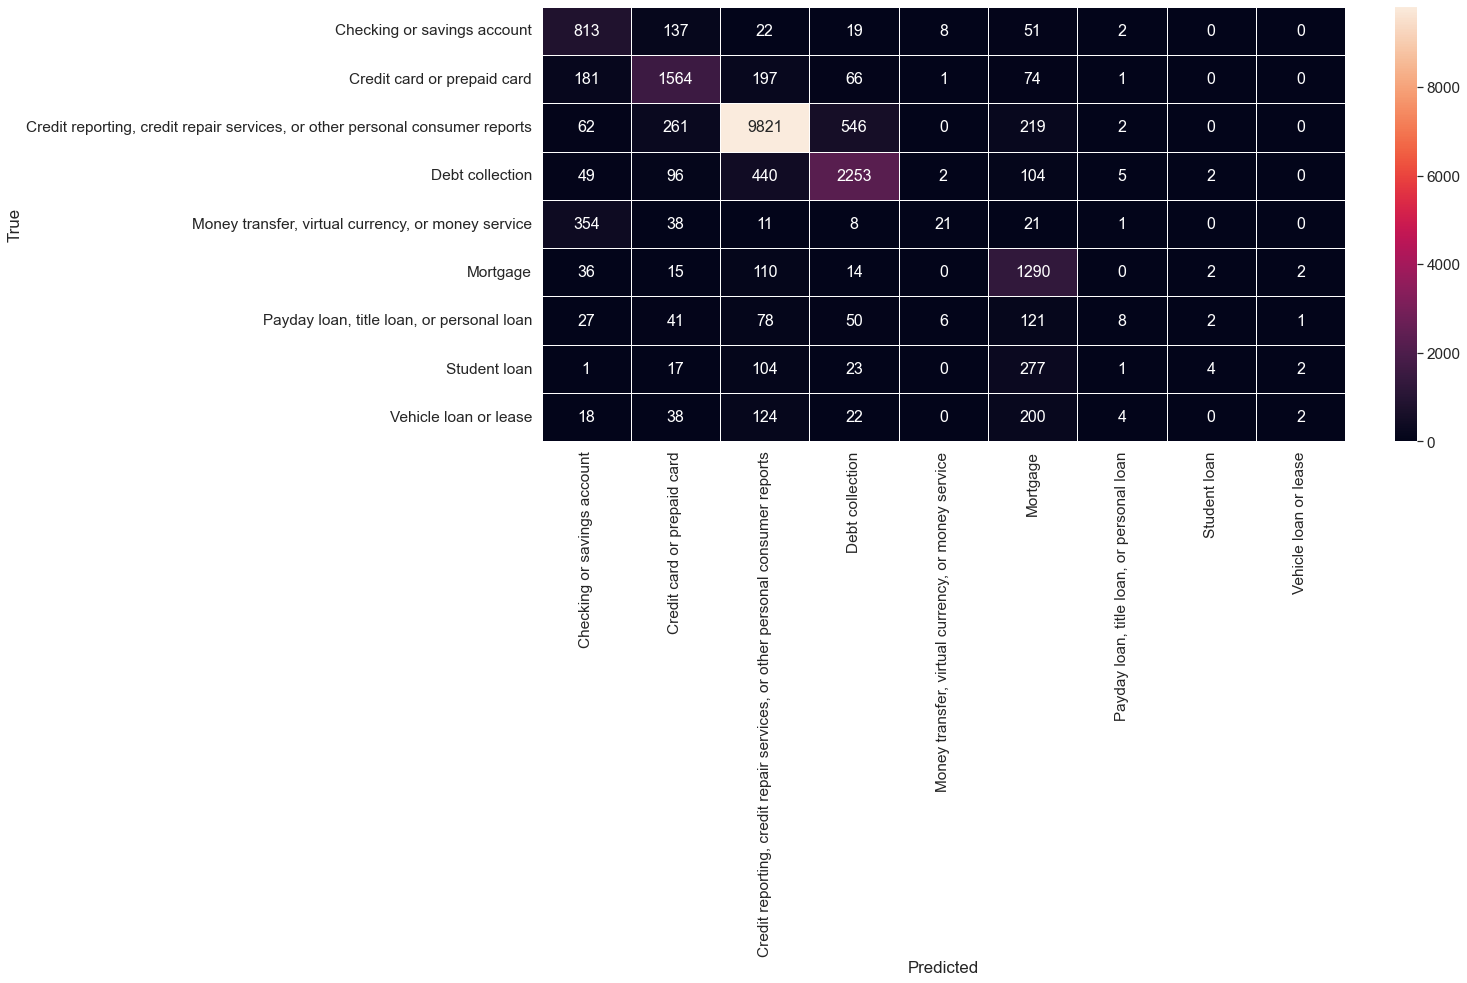

In [200]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()